In [1]:
#Imports
import PySAM
import PV_ICE
import pandas as pd
import numpy as np
import json
from PySAM import Pvsamv1 as pv
from PySAM import Pvwattsv8 as pvwatts
from PySAM import Cashloan as res
from PySAM import Grid as grid
from PySAM import Utilityrate5 as ur
import PySAM.Pvsamv1Tools as pvtools

In [2]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("PySAM version ", PySAM.__version__)
print("PV_ICE version ", PV_ICE.__version__)

Working on a  Windows 10
Python version  3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.4
PySAM version  7.0.0
PV_ICE version  0.4.4.dev2+g378a012.d20250320


### Residential Repowering Scenario
-Original system operates for X years

-Need for roof repair, other reason to take panels off roof in year X

-Calculate financials (net present value, payback period) for reinstalling existing panels vs. repowering with new modules


In [3]:
#Step 1. Set up original system
#Read in PySAM json
# create a new instance of the Pvwattsv8 module
pv_model = pv.default("FlatPlatePVResidential")
fin_model = res.from_existing(pv_model)
#Alternatively, use PVWatts
#pv_model = PySAM.Pvwattsv8.new()
grid_model = res.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)

#User: input json files from SAM
# json_file_folder = "Repower_example"
# json_files = next(os.walk(json_file_folder))[2]
# json_files.sort()
json_file = "repower_example_pvsamv1.json"
fin_json_file = "repower_example_cashloan.json"
# get the inputs from the JSON file
for json_file in os.listdir('repower_files'):
    with open( json_file, 'r') as f:
            pv_inputs = json.load( f )
    
    # iterate through the input key-value pairs and set the module inputs
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            pv_model.value(k, v)

fin_model = res.from_existing(pv_model)
#Alternatively, use PVWatts
#pv_model = PySAM.Pvwattsv8.new()
grid_model = res.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)


In [5]:
#Step 2. Download resource data
#Read in weather data from SAM, or use NSRDB downloads in SAM format, or use dictionary of solar data
#A. You already have a file
weather_file = "repower_weather_file.csv"
pv_model.SolarResource.solar_resource_file = weather_file

#B. solar_resource_data
# weather_data = PySAM.ResourceTools.SAM_CSV_to_solar_data(weather_file)
# solar_resource_data = {
#         'tz': tz, # timezone
#         'elev': elev, # elevation
#         'lat': lat, # latitude
#         'lon': lon, # longitude
#         'year': tuple(weather_data[0]), # year
#         'month': tuple(weather_data[1]), # month
#         'day': tuple(weather_data[2]), # day
#         'hour': tuple(weather_data[3]), # hour
#         'minute': tuple(weather_data[4]), # minute
#         'dn': tuple(weather_data[5]), # direct normal irradiance
#         'df': tuple(weather_data[6]), # diffuse irradiance
#         'gh': tuple(weather_data[7]), # global horizontal irradiance
#         'wspd': tuple(weather_data[8]), # windspeed
#         'tdry': tuple(weather_data[9]) # dry bulb temperature
#         }
# pv_model.unassign("solar_resource_file")
# pv_model.SolarResource.solar_resource_data = solar_resource_data

#C. Download from NSRDB
# 
# --- Initialize Solar Resource Fetcher with minimum parameters ---
# See function documentation for full parameter list

import geocoder

# replace with key and email address from https://developer.nrel.gov/signup/
sam_api_key = os.environ.get('NREL_API_KEY')
sam_email = os.environ.get('NREL_API_EMAIL')
# sam_api_key = nrel_developer_key
# sam_email = sam@email.com
geocode_api_key = ''  # optional, may be required for geocoder

# --- Location Coordinates ---

# Set geocode to True to use geocoding service API
geocode = False
if geocode:
    # See https://geocoder.readthedocs.io/ for different geocoding services
    g = geocoder.bing('golden, co', key=geocode_api_key)
    lon = g.latlng[1]
    lat = g.latlng[0]
else:
    lon = -105.22
    lat = 39.75
nsrdbfetcher = tools.FetchResourceFiles(
                tech='solar',
                nrel_api_key=sam_api_key,
                nrel_api_email=sam_email)

# --- List of (lon, lat) tuples or Shapely points ---
lon_lats = [(lon, lat)]
nsrdbfetcher.fetch(lon_lats)

# --- Get resource data file path ---
nsrdb_path_dict = nsrdbfetcher.resource_file_paths_dict
nsrdb_fp = nsrdb_path_dict[lon_lats[0]]
#pv_model.SolarResource.solar_resource_file = nsrdb_fp

In [6]:
#Step 3. Set decision point 
#Roof replacement year (years from system install), or year where decision is needed to be made between reinstall vs repower
decision_year = 10 #years

#Set module degradation from initial install to decision point
degradation_rate = pv_model.Lifetime.dc_degradation #sequence, variable length depending on SAM input, if flat rate then length=1
degradation_todate = 0 #initialize
if len(degradation_rate) > 1:
    degradation_todate = degradation_rate[-1] #Use last element in array for most recent year, degradation rates are not cumulative
else:
    degradation_todate = degradation_rate[0] * decision_year #Only 1 value

print(degradation_todate)

5.0


In [7]:
#Reinstall case - Unknown number of remaining years of life
reinstall = pv.from_existing(pv_model)
reinstall_financial = res.from_existing(fin_model)
grid_model = grid.from_existing(reinstall_financial)
ur_model = ur.from_existing(reinstall_financial)
repower = pv.from_existing(pv_model)
repower_financial = res.from_existing(fin_model)

remaining_years = np.arange(1, 15, 1)
reinstall_npv = []
reinstall_payback = []
reinstall.Losses.subarray1_nameplate_loss = degradation_todate #Set degradation calculation as a nameplate decrease in reinstalled module's power output
reinstall_system_capacity = reinstall.SystemDesign.system_capacity * 1000 #Wdc
reinstall_variable_cost = 0.43 #$/Wdc
reinstall_fixed_cost = 2400 #$
reinstall_financial.SystemCosts.total_installed_cost = reinstall_variable_cost * reinstall_system_capacity
#reinstall_financial.SystemCosts.total_installed_cost = reinstall_fixed_cost
for lifetime in remaining_years:
    reinstall.Lifetime.analysis_period = lifetime
    grid_model.Lifetime.analysis_period = lifetime
    ur_model.Lifetime.analysis_period = lifetime
    
    
    reinstall.execute()
    grid_model.execute()
    ur_model.execute()
    reinstall_financial.FinancialParameters.analysis_period = lifetime
    reinstall_financial.SystemOutput.degradation = [0]
    reinstall_financial.SystemOutput.gen = reinstall.Outputs.gen
    reinstall_financial.execute()
    reinstall_npv.append(reinstall_financial.Outputs.npv) #$
    reinstall_payback.append(reinstall_financial.Outputs.payback) #years

print(reinstall_npv)
print(reinstall_payback)


[555.4303149214062, 378.871985819061, 215.40964905247594, 64.0116098064788, -76.26971389183015, -206.3055058888364, -326.89656606233495, -438.7790235339085, -542.6293947703384, -639.0697161403658, -728.6718706742852, -811.962340977806, -889.4249086520342, -961.5045738722623]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [8]:
#Repower case - Known system size, lifetime
grid_model = grid.from_existing(repower_financial)
ur_model = ur.from_existing(repower_financial)

capacity_min = 5 #kW
capacity_max = 10 #kW

new_system_analysis_period = 30 #years
repower.Lifetime.analysis_period = new_system_analysis_period
grid_model.Lifetime.analysis_period = new_system_analysis_period
ur_model.Lifetime.analysis_period = new_system_analysis_period

new_system_capacity = 8 #kWDC
repower_cost_per_wdc = 2.76 #$/Wdc
repower_cost_flat = 10000 #$
repower_npv = 0
repower_payback = 0
#Select new module?
mod_dict = PySAM.Pvsamv1Tools.set_cec_module_library_selection(repower, "Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R")
print(mod_dict)

n_strings, n_combiners, n_inverters, calculated_system_capacity = pvtools.size_electrical_parameters(repower, new_system_capacity, 1.06)

repower.execute()
grid_model.execute()
ur_model.execute()
repower_financial.SystemOutput.gen = reinstall.Outputs.gen
repower_financial.SystemCosts.total_installed_cost = repower_cost_per_wdc * repower.SystemDesign.system_capacity * 1000
# repower_financial.SystemCosts.total_installed_cost = repower_cost_flat

repower_financial.execute()
repower_npv = repower_financial.Outputs.npv
repower_payback = repower_financial.Outputs.payback
    

This function does not set the bifaciality of a module based on the bifacial based on the lib_is_bifacial value. Please change cec_is_bifacial to 1 to make the module bifacial.
{'lib_manufacturer': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Maxeon Solar Technologies Ltd.'}, 'cec_material': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Mono-c-Si'}, 'lib_is_bifacial': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 0}, 'Unnamed: 4': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 400.359}, 'Unnamed: 5': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 377.7}, 'cec_area': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 1.9}, 'lib_length': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'lib_width': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'cec_n_s': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 112}, 'cec_i_sc_ref': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 13.06}, 'cec_v_oc_ref': {'Maxeon Solar

C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

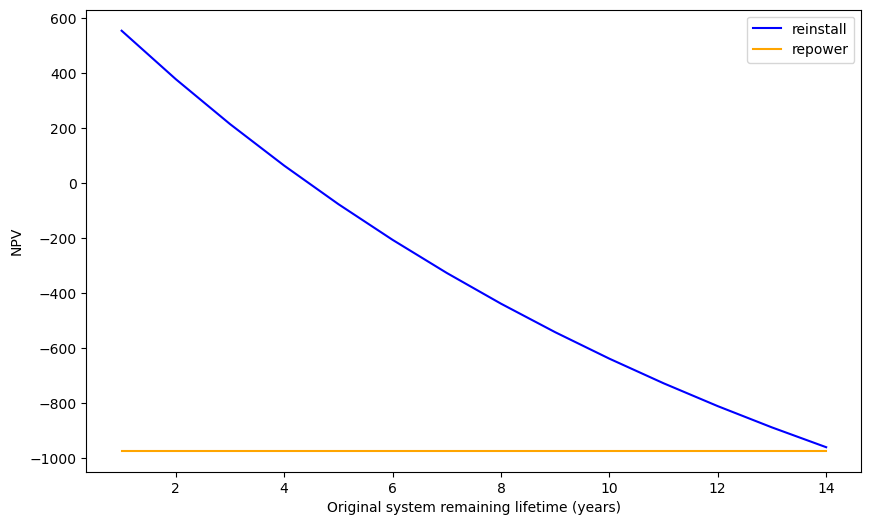

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data
data = pd.DataFrame({
    'x1': remaining_years,
    'y1': reinstall_npv,
    
})

data['y2'] = repower_npv

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(x='x1', y='y1', data=data, ax=ax1, color='blue', label='reinstall')
ax1.set_xlabel('Original system remaining lifetime (years)')
ax1.set_ylabel('NPV')

# Create the second x-axis
sns.lineplot(x='x1', y='y2', data=data, ax=ax1, color='orange', label='repower')
#ax2.set_xbound(ax1.get_xbound())
#plt.legend(['reinstall', 'repower'])

# Display the plot
plt.show()

In [15]:
#Repower case
grid_model = grid.from_existing(repower_financial)
ur_model = ur.from_existing(repower_financial)

capacity_min = 5 #kW
capacity_max = 10 #kW

new_system_analysis_period = 30 #years
repower.Lifetime.analysis_period = new_system_analysis_period
grid_model.Lifetime.analysis_period = new_system_analysis_period
ur_model.Lifetime.analysis_period = new_system_analysis_period

capacity_range = np.arange(8,12,0.2)
repower_cost_per_wdc = 0.80 #$/Wdc
repower_cost_flat = 10000 #$
repower_npv = []
repower_payback = []
#Select new module?
mod_dict = PySAM.Pvsamv1Tools.set_cec_module_library_selection(repower, "Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R")
print(mod_dict)
for sys_cap in capacity_range:
    n_strings, n_combiners, n_inverters, calculated_system_capacity = pvtools.size_electrical_parameters(repower, sys_cap, 1.06)
    
    repower.execute()
    grid_model.execute()
    ur_model.execute()
    repower_financial.SystemOutput.gen = reinstall.Outputs.gen
    repower_financial.SystemCosts.total_installed_cost = repower_cost_per_wdc * repower.SystemDesign.system_capacity * 1000
    # repower_financial.SystemCosts.total_installed_cost = repower_cost_flat

    repower_financial.execute()
    repower_npv.append(repower_financial.Outputs.npv)
    repower_payback.append(repower_financial.Outputs.payback)
    

This function does not set the bifaciality of a module based on the bifacial based on the lib_is_bifacial value. Please change cec_is_bifacial to 1 to make the module bifacial.
{'lib_manufacturer': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Maxeon Solar Technologies Ltd.'}, 'cec_material': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 'Mono-c-Si'}, 'lib_is_bifacial': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 0}, 'Unnamed: 4': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 400.359}, 'Unnamed: 5': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 377.7}, 'cec_area': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 1.9}, 'lib_length': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'lib_width': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': nan}, 'cec_n_s': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 112}, 'cec_i_sc_ref': {'Maxeon Solar Technologies Ltd. SPR-MAX3-400-COM-R': 13.06}, 'cec_v_oc_ref': {'Maxeon Solar

In [16]:
#Reinstall case - Unknown number of remaining years of life
reinstall = pv.from_existing(pv_model)
reinstall_financial = res.from_existing(fin_model)
grid_model = grid.from_existing(reinstall_financial)
ur_model = ur.from_existing(reinstall_financial)
repower = pv.from_existing(pv_model)
repower_financial = res.from_existing(fin_model)

lifetime = 15 #years, user input for years of remaining life
reinstall_npv = 0
reinstall_payback = 0
reinstall.Losses.subarray1_nameplate_loss = degradation_todate
reinstall_system_capacity = reinstall.SystemDesign.system_capacity * 1000 #Wdc
reinstall_variable_cost = 0.30 #$/Wdc
reinstall_fixed_cost = 2400 #$
reinstall_financial.SystemCosts.total_installed_cost = reinstall_variable_cost * reinstall_system_capacity
#reinstall_financial.SystemCosts.total_installed_cost = reinstall_fixed_cost

reinstall.Lifetime.analysis_period = lifetime
grid_model.Lifetime.analysis_period = lifetime
ur_model.Lifetime.analysis_period = lifetime


reinstall.execute()
grid_model.execute()
ur_model.execute()
reinstall_financial.FinancialParameters.analysis_period = lifetime
reinstall_financial.SystemOutput.degradation = [0]
reinstall_financial.SystemOutput.gen = reinstall.Outputs.gen
reinstall_financial.execute()
reinstall_npv = reinstall_financial.Outputs.npv #$
reinstall_payback = reinstall_financial.Outputs.payback #years

print(reinstall_npv)
print(reinstall_payback)


-1994.892415124436
nan


C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mprillim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

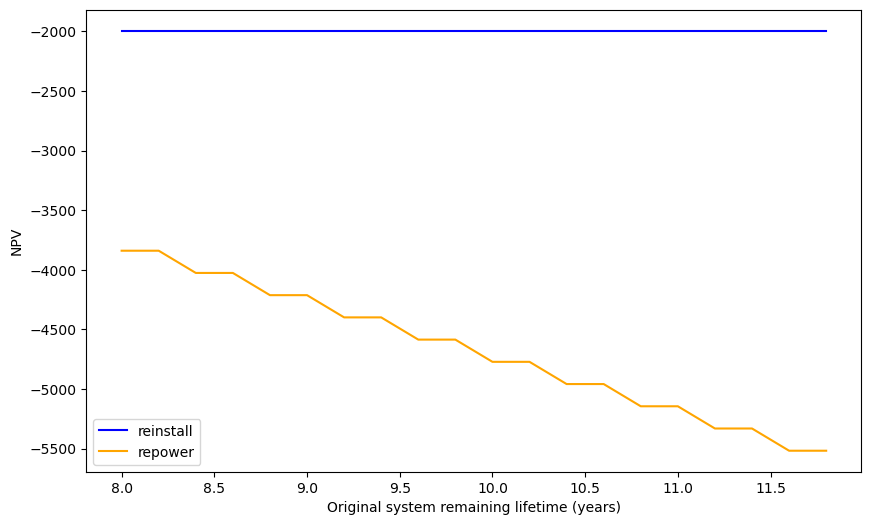

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data
data = pd.DataFrame({
    'x1': capacity_range,
    'y1': repower_npv,
    
})

data['y2'] = reinstall_npv

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(x='x1', y='y2', data=data, ax=ax1, color='blue', label='reinstall')
ax1.set_xlabel('Original system remaining lifetime (years)')
ax1.set_ylabel('NPV')

# Create the second x-axis
sns.lineplot(x='x1', y='y1', data=data, ax=ax1, color='orange', label='repower')
#ax2.set_xbound(ax1.get_xbound())
#plt.legend(['repower', 'reinstall'])

# Display the plot
plt.show()

In [13]:
#Make decision on repower vs install, run PV_ICE
import PV_ICE as pvice


In [14]:
#Second life for free case?
